### <Font color = 'indianred'>**Setting up the environment**

In [1]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate -U -qq
  basepath = '/content/drive/MyDrive/data/'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannorr/data'



Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00


In [2]:
# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn

# For working with textual data vocabularies and for displaying model summaries
from torchtext.vocab import vocab

# General-purpose Python libraries for random number generation and numerical operations
import random
import numpy as np

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter

# For creating lightweight attribute classes and for partial function application
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from pathlib import Path
from sklearn.metrics import confusion_matrix
from datetime import datetime

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, AutoModel
from transformers import AutoConfig
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import DataCollatorWithPadding
from transformers import PreTrainedModel, PretrainedConfig
from transformers import TrainingArguments, Trainer
from datasets import Dataset
from transformers import pipeline
import evaluate

# wandb library
import wandb

In [3]:
base_folder = Path('/content/drive/MyDrive/NLP/HW_6')
data_folder = base_folder
model_folder = base_folder/'Models'
custom_functions = base_folder/'custom_functions'

In [4]:
model_folder.mkdir(exist_ok=True, parents = True)

In [5]:
model_folder

PosixPath('/content/drive/MyDrive/NLP/HW_6/Models')

### <Font color = 'indianred'>**Load Data** </font>

In [6]:
import pandas as pd
train_df = pd.read_csv(data_folder / 'train.csv')

### <Font color = 'indianred'>**Check for distribution of word length per tweet** </font>

In [7]:
# check distribution of text length
train_df['words_per_Tweet'] = train_df['Tweet'].str.split().apply(len)

<Axes: >

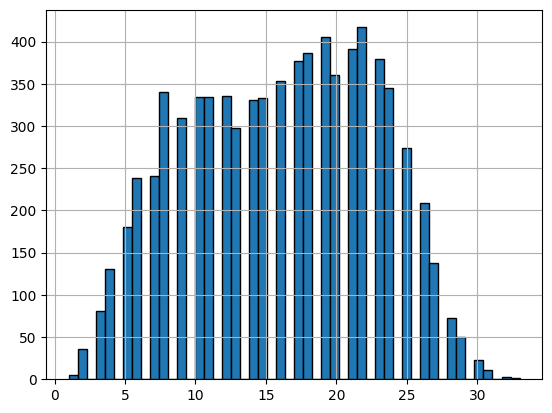

In [8]:
# Plot a histogram of the 'words_per_review' column
train_df['words_per_Tweet'].hist(bins=50, edgecolor='black')

### <Font color = 'indianred'>**Splitting and converting into dictionary** </font>

In [9]:
from sklearn.model_selection import train_test_split
X = train_df['Tweet']
y = train_df[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].values.astype(float)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


print("Training set length:", len(X_train), len(y_train))
print("Validation set length:", len(X_valid), len(y_valid))
print("Test set length:", len(X_test), len(y_test))

Training set length: 4634 4634
Validation set length: 1545 1545
Test set length: 1545 1545


In [10]:
from datasets import Dataset

trainset = Dataset.from_dict({
    'texts': X_train,
    'labels': y_train
})

validset = Dataset.from_dict({
    'texts': X_valid,
    'labels': y_valid
})

testset = Dataset.from_dict({
    'texts': X_test,
    'labels': y_test
})


In [11]:
from datasets import load_dataset, DatasetDict
# Combine training and validation sets into a DatasetDict for convenience
train_val = DatasetDict({"train": trainset, "valid": validset})

In [12]:
# View the first few labels from the training set
print("Training set labels:")
for i in range(3):  # Adjust the range to view more or fewer examples
    print(train_val['train'][i]['labels'])

# View the first few labels from the validation set
print("\nValidation set labels:")
for i in range(3):  # Adjust the range to view more or fewer examples
    print(train_val['valid'][i]['labels'])


Training set labels:
[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]

Validation set labels:
[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


### <Font color = 'indianred'>**Preprocessing data** </font>

In [13]:
checkpoint = "albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

In [14]:
def tokenize_fn(batch):
    return tokenizer(text = batch["texts"], truncation=True, padding=True, return_tensors="pt")

    #do not use padding here and also we cannot return tensors, so no return_tensors

In [15]:
tokenized_dataset= train_val.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['texts']
)
tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/4634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

### <Font color = 'indianred'>**Defining the model** </font>

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 11)  # We are using the same checkpiont as we have used for tokenizer


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
config = AutoConfig.from_pretrained(checkpoint)
config.problem_type = "multi_label_classification"
class_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
config.id2label = id2label
config.label2id = label2id
model.config = config

In [18]:
config

AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_typ

In [19]:
model

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [20]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, hamming_loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Apply sigmoid to the logits to get probabilities
    probabilities = 1 / (1 + np.exp(-logits))
    # Choosing appropriate threshold and converting into predictions
    predictions = (probabilities >= 0.46).astype(int)
    #print(np.average(probabilities))

    # Metrics calculation
    accuracy = accuracy_score(labels.flatten(), predictions.flatten())
    f1 = f1_score(labels, predictions, average='macro', zero_division=0)
    precision = precision_score(labels, predictions, average='macro', zero_division=0)
    recall = recall_score(labels, predictions, average='macro', zero_division=0)
    hamming = hamming_loss(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'hamming_loss': hamming
    }


### <Font color = 'indianred'>**Training the model** </font>

In [22]:
# Define the directory where model checkpoints will be saved
run_name = "Multilabel Project with albert-base-v2 model"
base_folder = Path(basepath)
model_folder = base_folder / "models"/run_name
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=3,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # auto_find_batch_size=True,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=100,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=100,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=100,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    fp16=True,


)


In [23]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [24]:
wandb.login()
%env WANDB_PROJECT = multilabel_bert

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=multilabel_bert


In [25]:
trainer.train()

wandb: Currently logged in as: prafulp659 (utd659). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hamming Loss,Runtime,Samples Per Second,Steps Per Second
100,0.485100,0.441125,0.811474,0.167265,0.254427,0.144698,0.188526,1.832000,843.357000,52.949000
200,0.416800,0.403727,0.826655,0.245848,0.237708,0.255223,0.173345,1.939600,796.576000,50.012000
300,0.395100,0.389708,0.832833,0.306939,0.341257,0.306705,0.167167,1.918300,805.407000,50.566000
400,0.366600,0.380612,0.838717,0.295210,0.371309,0.283905,0.161283,1.985300,778.211000,48.859000
500,0.355500,0.366472,0.847485,0.337107,0.375044,0.313220,0.152515,1.846900,836.545000,52.521000
600,0.339700,0.363324,0.847190,0.356543,0.358451,0.359075,0.152810,1.857700,831.656000,52.214000
700,0.314600,0.354461,0.853192,0.357956,0.552215,0.333526,0.146808,1.831200,843.730000,52.972000
800,0.317000,0.353356,0.852368,0.365575,0.563785,0.344659,0.147632,1.814900,851.264000,53.445000


TrainOutput(global_step=870, training_loss=0.3691688800680226, metrics={'train_runtime': 65.4055, 'train_samples_per_second': 212.551, 'train_steps_per_second': 13.302, 'total_flos': 46050473449332.0, 'train_loss': 0.3691688800680226, 'epoch': 3.0})

In [26]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [27]:
eval_results

{'eval_loss': 0.35446083545684814,
 'eval_accuracy': 0.8531921153280376,
 'eval_f1': 0.35795620810139045,
 'eval_precision': 0.5522147123007278,
 'eval_recall': 0.33352618075045654,
 'eval_hamming_loss': 0.14680788467196235,
 'eval_runtime': 1.8692,
 'eval_samples_per_second': 826.536,
 'eval_steps_per_second': 51.893,
 'epoch': 3.0}

In [28]:
wandb.log({"eval_accuracy": eval_results["eval_accuracy"], "eval_loss": eval_results["eval_loss"], "eval_f1": eval_results["eval_f1"]})

In [29]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 700.


### <Font color = 'indianred'>**Evaluating the model on test set through checkpoint** </font>

In [30]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/drive/MyDrive/data/models/Multilabel Project with albert-base-v2 model/checkpoint-700'

In [31]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [32]:
test_set_tokenized = testset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [33]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=128,
    do_train=False,
    do_eval=True,
    report_to=[],
    run_name=run_name
)

In [34]:
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_set_tokenized,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [35]:
test_results= trainer.evaluate()

In [36]:
test_results

{'eval_loss': 0.35743579268455505,
 'eval_accuracy': 0.8510738452486025,
 'eval_f1': 0.3601421216834545,
 'eval_precision': 0.48856123290999526,
 'eval_recall': 0.33562784082821673,
 'eval_hamming_loss': 0.14892615475139748,
 'eval_runtime': 0.7908,
 'eval_samples_per_second': 1953.723,
 'eval_steps_per_second': 16.439}

In [37]:
wandb.log({"test_accuracy": test_results["eval_accuracy"], "test_loss": test_results["eval_loss"], "test_f1": test_results["eval_f1"]})

In [38]:
wandb.finish()

eval/accuracy,▁▄▅▆▇▇███
eval/f1,▁▄▆▆▇████
eval/hamming_loss,█▅▄▃▂▂▁▁▁
eval/loss,█▅▄▃▂▂▁▁▁
eval/precision,▁▁▃▄▄▄███
eval/recall,▁▅▆▆▇█▇█▇
eval/runtime,▂▆▅█▂▃▂▁▃
eval/samples_per_second,▇▃▄▁▇▆▇█▆
eval/steps_per_second,▇▃▄▁▇▆▇█▆
eval_accuracy,▁
eval_f1,▁


### <Font color = 'indianred'>**Inference** </font>

In [39]:
text = "I'm stressed about the experiment 3 where i need to use Flan T5 model"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

In [40]:
logits = outputs.logits
logits.shape

torch.Size([1, 11])

In [41]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

['sadness']
